https://gis.stackexchange.com/questions/350771/earth-engine-simplest-way-to-move-from-ee-image-to-array-for-use-in-sklearn

# Combine data from Google Earth Engine (GEE) and Geoscience Australia (GA)

GEE is a geospatial processing service. It has the option to be run through it's online JavaScript Code Editor, or can be accessed in python platforms such as Colab and Jupyter Notebooks. GEE provides access to many different datasets, including Sentinel 1, Landsat, PALSAR and MODIS (https://developers.google.com/earth-engine/datasets/catalog). 

To get started with GEE these links may help:
- User guides: https://developers.google.com/earth-engine/guides
- Get started using GEE with python: https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb

## Setup

#### Install GEE API

In [2]:
!pip install -U earthengine-api

     |████████████████████████████████| 150 kB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 10.0 MB/s eta 0:00:01
  Using cached google_api_python_client-1.12.8-py2.py3-none-any.whl (61 kB)
  Using cached google_auth_httplib2-0.0.4-py2.py3-none-any.whl (9.1 kB)
  Using cached httplib2-0.18.1-py3-none-any.whl (95 kB)
Processing /home/jovyan/.cache/pip/wheels/50/6c/00/2a8868de404e13a77667ff2c94e908e7cff9acd1d1dd307a48/httplib2shim-0.0.3-py2.py3-none-any.whl
  Using cached google_resumable_media-1.2.0-py2.py3-none-any.whl (75 kB)
  Using cached google_cloud_core-1.5.0-py2.py3-none-any.whl (27 kB)
  Using cached google_api_core-1.24.0-py2.py3-none-any.whl (91 kB)
  Using cached uritemplate-3.0.1-py2.py3-none-any.whl (15 kB)
  Using cached google_crc32c-1.1.0-cp36-cp36m-manylinux2010_x86_64.whl (39 kB)
  Using cached googleapis_common_protos-1.52.0-py2.py3-none-any.whl (100 kB)
  Created wheel for earthengine-api: filename=earthengine_api-0.1.246-py3-none-any.whl size

#### Import modules

In [29]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import sys
import folium
import datacube
import odc.ui
from odc.ui import with_ui_cbk

sys.path.append("/home/jovyan/Scripts")
from dea_plotting import display_map
from dea_plotting import rgb

In [4]:
dc = datacube.Datacube(app='gee')

#### Authenticate

In [5]:
ee.Authenticate()

Enter verification code:  4/1AY0e-g6buD_bgC7TmzG4ZvVk1o11OM0JqyYc5Iz4kRkqOlJ-hT-f-dpWjJg



Successfully saved authorization token.


In [6]:
ee.Initialize()

## Load Imagery

### Define parameters 

In [21]:
# Define parameters

# Dates
# NOTE: GEE dates are inclusive and GA are exclusive on the end date
start = '2019-03-01'
end = '2019-09-01'
end_ga = '2019-09-30'

# Set the central latitude and longitude
central_lat = -35.293005
central_lon = 149.119980

In [8]:
# Set the buffer to load around the central coordinates
buffer = 0.005 # must be small for .sampleRectangle() to work

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

### Load GEE imagery

To load imagery from GEE generally you will need to:
- define an area of interest and pass to `filterBounds`
- define a time period of interest and pass to `filterDate`
- filter on metadata (commonly cloud cover)
- select bands of interest
- reproject

Imagery without a set projection will be called in WGS 94. Landsat pixels in GEE have ar 30m in length, compared to Landsat pixels in GA.

>**Note**: All options for how to manipulate GEE objects can be found here https://developers.google.com/earth-engine/apidocs

In [9]:
# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[study_area_lon[0], study_area_lat[0]],
    [study_area_lon[0], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[0]]]], None, False)

### Example 1 - qa band

This is from the Code Editor https://code.earthengine.google.com/ Examples > Scripts > Sentinel2

This example uses the Sentinel-2 QA band to cloud mask the collection.  The Sentinel-2 cloud flags are less selective, so the collection is also pre-filtered by the CLOUDY_PIXEL_PERCENTAGE flag, to use only relatively cloud-free granule.

In [10]:
# Function to mask clouds using the Sentinel-2 QA band.
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Return the masked and scaled data, without the QA bands.
    return (image.updateMask(mask) #.divide(10000)
         .select("B.*")
         .copyProperties(image, ["system:time_start"]))

# Map the function over one year of data and take the median.
# Load Sentinel-2 TOA reflectance data.
collection = (ee.ImageCollection('COPERNICUS/S2')
               .filterDate(start, end)
               # Pre-filter to get less cloudy granules.
               .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
               .map(maskS2clouds))

composite = collection.median()

# // Display the results.
# Map.addLayer(composite, {bands: ['B4', 'B3', 'B2'], min: 0, max: 0.3}, 'RGB')


In [11]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [12]:
# Set visualization parameters.
viz = {
  'min': 0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2']}

# Create a folium map object.
composite_map = folium.Map(location=[central_lat, central_lon], zoom_start=16, height=500)

# Add the elevation model to the map object.
composite_map.add_ee_layer(composite.clip(aoi), viz, 'composite')

# Add a layer control panel to the map.
composite_map.add_child(folium.LayerControl())

# Display the map.
display(composite_map)

### Example 2 - use cloud displacement index

This is from the Code Editor https://code.earthengine.google.com/ Examples > Scripts > Sentinel2 Cloud and Shadow

This example demonstrates the use of the COPERNICUS/S2_CLOUD_PROBABILITY dataset, the `ee.Algorithms.Sentinel2.CDI()` method for computing a cloud displacement index and `directionalDistanceTransform()` for computing cloud shadows.

In [13]:
# Sentinel-2 Level 1C data.  Bands B7, B8, B8A and B10 from this
# dataset are needed as input to CDI and the cloud mask function.
s2 = ee.ImageCollection('COPERNICUS/S2')

# Cloud probability dataset.  The probability band is used in
# the cloud mask function.
s2c = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
# Sentinel-2 surface reflectance data for the composite.
s2Sr = ee.ImageCollection('COPERNICUS/S2_SR')

# S2 L1C for Cloud Displacement Index (CDI) bands.
s2 = s2.filterBounds(aoi).filterDate(start, end).select(['B7', 'B8', 'B8A', 'B10'])
# S2Cloudless for the cloud probability band.
s2c = s2c.filterDate(start, end).filterBounds(aoi)
# S2 L2A for surface reflectance bands.
s2Sr = s2Sr.filterDate(start, end).filterBounds(aoi).select(['B2', 'B3', 'B4', 'B5'])

# Join two collections on their 'system:index' property.
# The propertyName parameter is the name of the property
# that references the joined image.
def indexJoin(collectionA, collectionB, propertyName):
    joined = ee.ImageCollection(ee.Join.saveFirst(propertyName).apply(
    primary= collectionA,
    secondary= collectionB,
    condition= ee.Filter.equals(
      leftField= 'system:index',
      rightField= 'system:index')
  ))
  # Merge the bands of the joined image.
    return joined.map(lambda image: image.addBands(ee.Image(image.get(propertyName))))

# Aggressively mask clouds and shadows.
def maskImage(image):
  # Compute the cloud displacement index from the L1C bands.
  cdi = ee.Algorithms.Sentinel2.CDI(image)
  s2c = image.select('probability')
  cirrus = image.select('B10').multiply(0.0001)

  # Assume low-to-mid atmospheric clouds to be pixels where probability
  # is greater than 65%, and CDI is less than -0.5. For higher atmosphere
  # cirrus clouds, assume the cirrus band is greater than 0.01.
  # The final cloud mask is one or both of these conditions.
  isCloud = s2c.gt(65).And(cdi.lt(-0.5)).Or(cirrus.gt(0.01))

  # Reproject is required to perform spatial operations at 20m scale.
  # 20m scale is for speed, and assumes clouds don't require 10m precision.
  isCloud = isCloud.focal_min(3).focal_max(16)
  isCloud = isCloud.reproject(crs=cdi.projection(), scale=20)

  # Project shadows from clouds we found in the last step. This assumes we're working in
  # a UTM projection.
  shadowAzimuth = ee.Number(90).subtract(ee.Number(image.get('MEAN_SOLAR_AZIMUTH_ANGLE')))

  # With the following reproject, the shadows are projected 5km.
  isCloud = isCloud.directionalDistanceTransform(shadowAzimuth, 50)
  isCloud = isCloud.reproject(crs=cdi.projection(), scale= 100)

  isCloud = isCloud.select('distance').mask()
  return image.select('B2', 'B3', 'B4').updateMask(isCloud.Not())

# Join the cloud probability dataset to surface reflectance.
withCloudProbability = indexJoin(s2Sr, s2c, 'cloud_probability')
# Join the L1C data to get the bands needed for CDI.
withS2L1C = indexJoin(withCloudProbability, s2, 'l1c')

# Map the cloud masking function over the joined collection.
masked = ee.ImageCollection(withS2L1C.map(maskImage))

# Take the median, specifying a tileScale to avoid memory errors.
median = masked.reduce(ee.Reducer.median(), 8).clip(aoi)

# # Display the results.
# viz = {bands: ['B4_median', 'B3_median', 'B2_median'], min: 0, max: 3000};
# Map.addLayer(median, viz, 'median')

# Print information
print('s2Sr',s2Sr.median().getInfo())
print()
print('Median',median.getInfo())
print()
print('s2Sr',s2Sr.first().getInfo().get('bands')[0].get('crs'))

s2Sr {'type': 'Image', 'bands': [{'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}

Median {'type': 'Image', 'bands': [{'id': 'B2_median', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'dimensions': [1, 1], 'origin': [149, -36], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B3_median', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535}, 'dimen

In [14]:
# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2']}

vis_params_masked = {
  'min': 0,
  'max': 3000,
  'bands': ['B4_median', 'B3_median', 'B2_median']}

# Create a folium map object.
my_map = folium.Map(location=[central_lat, central_lon], zoom_start=16, height=500)

# Add the elevation model to the map object.
my_map.add_ee_layer(s2Sr.median().clip(aoi), vis_params, 's2Sr median')
my_map.add_ee_layer(median.clip(aoi), vis_params_masked, 'cloud masked median')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

### Convert GEE image into a numpy array

The image returned to us is an ee.Image object. To integrate this with GA imagery, we need to convert the image object into an xarray.

In [15]:
# You must reproject to GA compatiable crs before converting to an array
median_reproj = median.reproject('EPSG:4326',None,10).clip(aoi)

In [16]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = median_reproj.sampleRectangle(region=aoi)
# print('band_arrs',band_arrs.shape)

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B2_median') #B2
band_arr_b5 = band_arrs.get('B3_median') #B3
band_arr_b6 = band_arrs.get('B4_median') #B4
# print('band_arr_b6',band_arr_b6)

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())
print('np_arr_b6',np_arr_b6.shape)



np_arr_b6 (112, 112)


In [17]:
# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b4_ex = np.expand_dims(np_arr_b4, 2)
np_arr_b5_ex = np.expand_dims(np_arr_b5, 2)
np_arr_b6_ex = np.expand_dims(np_arr_b6, 2)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b6_ex, np_arr_b5_ex, np_arr_b4_ex), 2)
print(rgb_img.shape)

(112, 112, 3)


### Display new numpy array

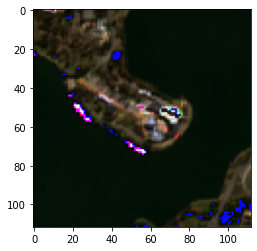

In [53]:
# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((rgb_img - 100)/3000)).astype('uint8')

plt.imshow(rgb_img_test)
plt.show()

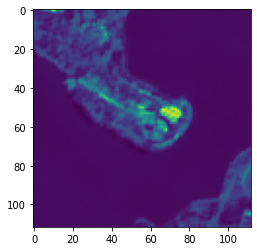

In [19]:
# Display a single band
plt.imshow(rgb_img[:,:,0])
plt.show()

### Load GA data

In [139]:
#Load all data in baseline period available from Near Real Time data
gas2 = dc.load(
          product=['ga_s2a_ard_nbar_granule'],
          measurements=['nbar_red','nbar_green','nbar_blue'],
          x= study_area_lon,
          y= study_area_lat,
          time=('2019-01-01', '2019-02-01'),
#           output_crs='EPSG:4326',
#           resolution=(-0.0001,0.0001),
          output_crs='EPSG:3577',
          resolution=(-10,10)
            
)

In [140]:
array = gas2.isel(time=0).to_array().transpose("x", "y", "variable").values

In [141]:
# m = folium.Map([37, 0], zoom_start=1, tiles="OpenStreetMap",crs='EPSG4326')
m = folium.Map(location=[central_lat, central_lon], zoom_start=16, height=500)

folium.raster_layers.ImageOverlay(
    image=array,
    name="Your array",
    bounds= [[study_area_lat[0], study_area_lon[0]],[study_area_lat[1], study_area_lon[1]]], 
#     bounds=[[-82, -180], [82, 180]],
    opacity=1,
    interactive=False,
    cross_origin=False,
    zindex=1,
    mecator_project=True
).add_to(m)

folium.LayerControl().add_to(m)


m

In [132]:
# # Display wofs data
# plt.imshow(gas2.isel(time=0).to_array())
# plt.show()

In [133]:
# f, (ax1, ax2) = plt.subplots(1,2)
# ax1.imshow(np.array(wofs['count_wet'][0,:,:]))
# ax1.set_title('DEA Wofs')
# ax2.imshow(rgb_img_test)
# ax2.set_title('GEE Satellite Imagery')